# Setup and Imports
We will download the necessary libraries and embedding models 

In [ ]:
!pip install ratelimit
!pip install flair
!pip install transformers
!pip install rgf_python
!pip install textstat
!pip install pytorch-tabnet
!pip install shap
!python -m spacy download en_core_web_lg
!wget https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-en-19.08.txt.gz
!gzip -d ./numberbatch-en-19.08.txt.gz
!wget https://www.dropbox.com/s/1m0ofr06zy0nnbm/gpt2glecmed.zip?dl=0
!unzip gpt2glecmed.zip\?dl\=0

In [2]:
import pandas as pd
import numpy as np
import regex as re
import requests
from nltk.corpus import wordnet as wn
import nltk
from nltk.stem import SnowballStemmer
from tqdm.notebook import tqdm
import spacy
import en_core_web_lg
import gensim.downloader
from flair.embeddings import TransformerDocumentEmbeddings
from flair.data import Sentence
from scipy import spatial
from json import JSONDecodeError   
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from ratelimit import limits, sleep_and_retry
from flair.embeddings import TransformerWordEmbeddings,TransformerDocumentEmbeddings,WordEmbeddings,FlairEmbeddings
from flair.data import Sentence

nlp =en_core_web_lg.load()
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Read and Preprocess the corpus

In [ ]:
from preprocess import read_text,preprocess_column
df=read_text('./464katz_mets_nader.txt')
df.label=df.label.astype(int)
df['processed_metaphor']=preprocess_column(df.M.values)

# Document based features

In this section, we're going to use an ensemble of transformer based document embedding to embed the metaphors, then use the concatenated vector to predict the binary target (literary/non-literary)  
The ensemble uses transformers fine tuned on different applications, this includes: part-of-speech tagging, language modeling and sentiment classifiaction. The intuition behind this is that finetuned transformers on different task would encompass different semantic features of the metaphors. 

In [ ]:
from flair.embeddings import TransformerDocumentEmbeddings
from flair.data import Sentence
# compute the embeddings for each model and stack them together
docs_e=[]
models=['vblagoje/bert-english-uncased-finetuned-pos','gpt2-xl','facebook/bart-large-cnn','bhadresh-savani/distilbert-base-uncased-emotion']
lengths=[]
for model in models:
  doc_embedding = TransformerDocumentEmbeddings(model)
  #store the embedding length for later usage
  lengths.append(doc_embedding.embedding_length)
  doc_e=[]
  for d in tqdm(df.M):
    sent=Sentence(d)
    doc_embedding.embed(sent)
    doc_e.append(sent.embedding.detach().cpu().numpy())
  docs_e.append(doc_e)
stacked_embeddings=docs_e[0]
for d in docs_e[1:]:
  stacked_embeddings=np.concatenate((stacked_embeddings,d),axis=1)

In [94]:
X=np.array(stacked_embeddings)
y=df.label.values

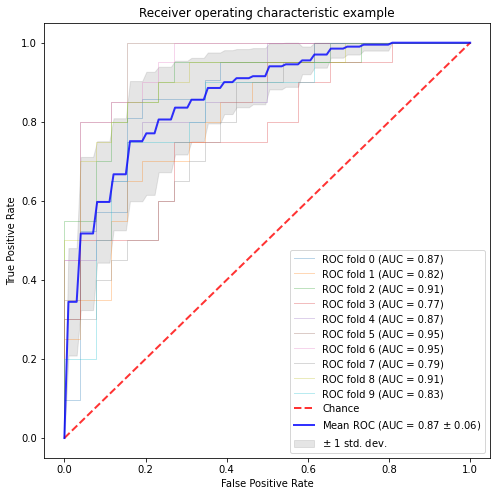

In [95]:
from utils import plot_auc_cv
plot_auc_cv(LogisticRegressionCV(max_iter=2000),X,y)

In [101]:
from classifiers import classifiers_auc
classifiers_auc(X,y,2)

0it [00:00, ?it/s]

SVM  AUC:  0.8445436024371668
Naive Bayes  AUC:  0.7703423457730388
Logistic Regression  AUC:  0.827866717440975
Knn  AUC:  0.779517517136329
Gradient Boosting Trees  AUC:  0.727222581873572
Random Forest  AUC:  0.8254044173648134
RGF  AUC:  0.8188415841584158
XGBoost  AUC:  0.8190079969535415
ERT  AUC:  0.8355057121096725


On 2 cross validation iterations only eg. only half of the data is used for training, the model can reach 0.8445 AUC.

### visualizing embedding model importance
this section fits an ERT to the ensembled Transformer embeddings, and then aggregates the feature importance for each transformer model.    
We note that gpt2-xl contains the most information about literariness of metaphors. 

ERT Fitness:  1.0


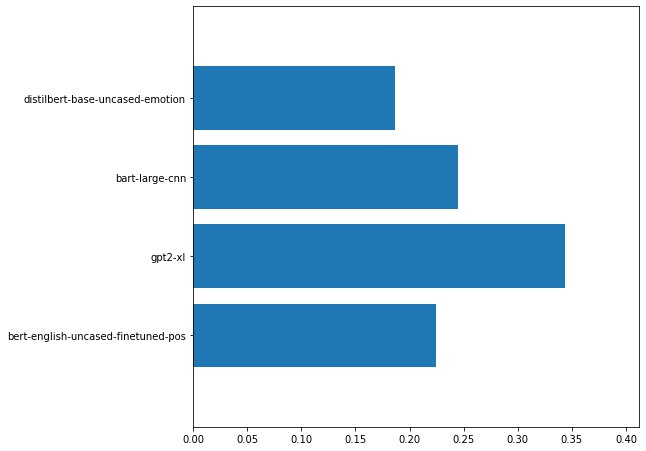

In [97]:
from utils import plot_hbar
clf=ExtraTreesClassifier(n_estimators=1000,max_depth=15)
clf.fit(X,y)
print("ERT Fitness: ",clf.score(X,y))
feature_importances=clf.feature_importances_
init=0
model_names=['bert-english-uncased-finetuned-pos','gpt2-xl','bart-large-cnn','distilbert-base-uncased-emotion']
#aggregate feature importance for each transformer
model_importances=[]
for i in np.cumsum(lengths):
  model_imp=np.sum(feature_importances[init:i])
  model_importances.append(model_imp)
  init=i
plot_hbar(data)

# Flair Classifier
In this section we train a flair classifier with the gpt2-medium finetuned document embedding, we report 5 cross validation results on the dataset, and notice the surprising good performance (excellent auc .90-1) of this classifier.     

In [ ]:
from flair.data_fetcher import NLPTaskDataFetcher
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,auc,roc_auc_score
from flair.trainers import ModelTrainer
from flair.models import TextClassifier
from flair.datasets import CSVClassificationCorpus
from pathlib import Path
import sklearn.metrics as metrics
import os
import matplotlib.pyplot as plt
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8,8))
column_name_map = {0: "text", 1: "label"}
label_map={'0':'nonliterary','1':'literary'}
skf = StratifiedKFold(n_splits=5)
document_embedding=TransformerDocumentEmbeddings('./gpt2_medium_glec/')
model_results=[]
X=df.M.values
y=df.label.values

for train_index, test_index in tqdm(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    tdf=pd.DataFrame({0:X_train,1:y_train.astype(str)})
    tdf[1]=tdf[1].map(label_map)
    tdf.to_csv('./train.csv',index=False)
    tdf2=pd.DataFrame({0:X_test,1:y_test.astype(str)})
    tdf2[1]=tdf2[1].map(label_map)

    tdf2.to_csv('./test.csv',index=False)
    # corpus = NLPTaskDataFetcher.load_classification_corpus(Path('./'), test_file='test.csv', train_file='train.csv')
    corpus=CSVClassificationCorpus(Path('./'),column_name_map,label_type='class',skip_header=True)
    classifier = TextClassifier(document_embedding,label_type='class', label_dictionary=corpus.make_label_dictionary('class'), multi_label=False)
    trainer = ModelTrainer(classifier, corpus)
    trainer.train('./', max_epochs=10,mini_batch_size=4,learning_rate=.01,anneal_against_dev_loss=True)
    model_score=[]
    for s in X_test:
      s=Sentence(s)
      classifier.predict(s)
      score=(s.labels[0].score if s.labels[0].value =='literary' else 1-s.labels[0].score)
      model_score.append(score)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model_score)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc=roc_auc_score(y_test,model_score)
    model_results.append(roc_auc)
    aucs.append(roc_auc)
    os.remove("./dev.tsv")
    os.remove("./test.tsv")
    os.remove("./loss.tsv")
    os.remove("training.log")
    os.remove("final-model.pt")
    os.remove("./best-model.pt")
    os.remove("./weights.txt")



ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (np.mean(aucs), np.std(aucs)),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

# Word based embeddings

This section investigates word level features, the features include the word tenor vehicle relation with different embedding models, the cosine similarity between the metaphor words from different embedding models, sentiment and confidence score, ease of readness, and the gltr word statistics. 
There are 14 features in total which makes this approach explainable. 

### Featurize the dataset

In [ ]:
from featurize import featurize
labels=[
        'gltr_mean','gltr_std','gltr_max','gltr_cond_p','flair_mean','flair_std','flair_explaind_sum','conceptnet_t/v_sim','sentiment','sentiment_confidence','flescher_reading_index','ARI'
]
X=featurize(df)
X1=np.array(X)
X2=df[df.columns[4:]].values
y=df.label.values

In [9]:
df_met = pd.DataFrame(data=X1, index=np.arange(X1.shape[0]), columns=labels)
df_met['label']=y
df_met.to_csv("metaphors_data.csv")

### Tabnet Benchmark using the generated features

In [123]:
from classifiers import tabnet_auc
results,feature_importances=tabnet_auc(X1,y,10)

0it [00:00, ?it/s]

No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
Tabnet AUC: 0.7206593406593407


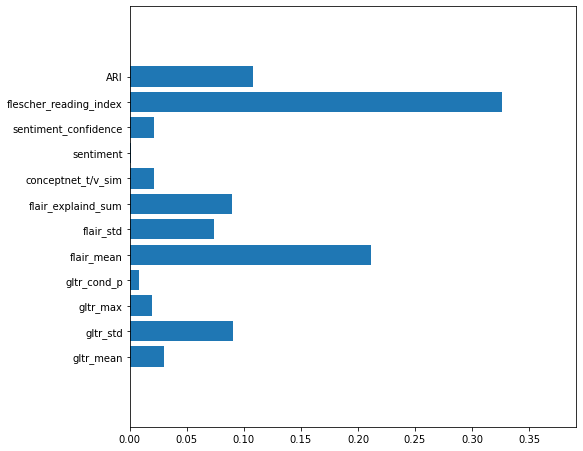

In [124]:
data = {k:v for k,v in zip(labels,feature_importances)}
plot_hbar(data)

### Benchmarking different machine learning models

In [106]:
from classifiers import classifiers_auc
classifiers_auc(X1,y)

0it [00:00, ?it/s]

SVM  AUC:  0.7308516483516483
Naive Bayes  AUC:  0.7314102564102565
Logistic Regression  AUC:  0.7448260073260075
Knn  AUC:  0.6600412087912089
Gradient Boosting Trees  AUC:  0.655746336996337
Random Forest  AUC:  0.7013827838827839
RGF  AUC:  0.6712179487179488
XGBoost  AUC:  0.6659432234432234
ERT  AUC:  0.7159157509157509


# Visualizing Feature importances and effects for ERT and LogisticRegression classifiers

Since ERT and Logisitic regression are the best performers , we will analyze their prediction and the feature impact on the models predictions

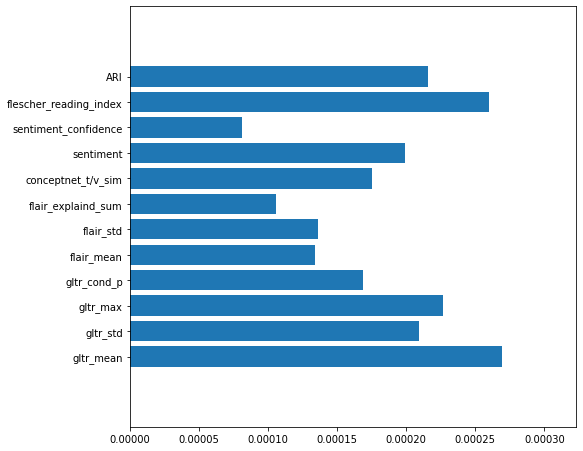

In [109]:
scl=StandardScaler()
X=scl.fit_transform(X1)
clf=ExtraTreesClassifier(n_estimators=1000,max_depth=6).fit(X,y)
data = {k:v for k,v in zip(df_met.columns[:-1],clf.feature_importances_)}
plot_hbar(data)

#### LogisticRegression Feature Impact

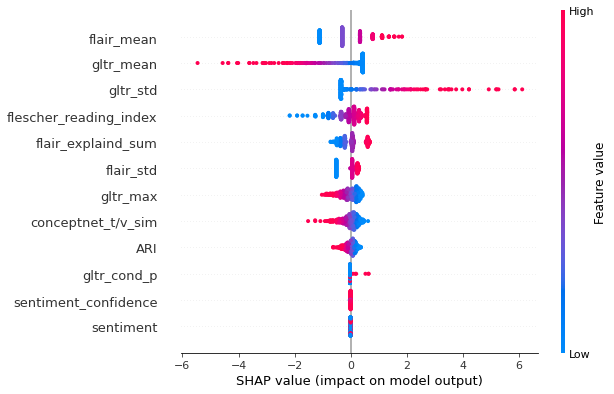

In [115]:
scl=StandardScaler()
X=scl.fit_transform(X1)
clf=LogisticRegressionCV().fit(X,y)
explainer = shap.LinearExplainer(clf, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=df_met.columns[:-1])


### Insights:
1- Flescher reading index is informative for literary metaphors detection, literary metaphors tend to be less confusing.   
2- Literary metaphors tend to have greater mean embedding distance, which means they spann wider concepts.  
3- Literary metaphors tend to be more surprising for a transformer model 

# Regression Tasks
The 14 features seem to only somewhat work for SRL, MGD, ALT and MET ratings only.

In [127]:
columns=["CMP","ESI","MET","MGD","SRL","MIM","IMS","IMP","FAM","ALT"]
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import accuracy_score,auc,roc_auc_score,mean_absolute_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV,LinearRegression
for col in columns:
  y=df[col].values
  skf = KFold(n_splits=10)

  models=[
          ("SVM",SVR(kernel='rbf')),
          ("LinearRegression",LinearRegression()),
          ("Ridge",RidgeCV()),
          ('Knn',KNeighborsRegressor(n_neighbors=3)), 
          ("ERT",ExtraTreesRegressor(n_estimators=1000,max_depth=9)),
          ]
  model_results={k[0]:[] for k in models}

  for train_index, test_index in tqdm(skf.split(X1, y)):
      X_train, X_test = X1[train_index], X1[test_index]
      y_train, y_test = y[train_index], y[test_index]
      scl=StandardScaler()
      X_train=scl.fit_transform(X_train)
      X_test=scl.transform(X_test)
      for m in models:
        m[1].fit(X_train,y_train)
        model_results[m[0]].append(mean_absolute_error(y_test,m[1].predict(X_test)))
  print("Predicting: ",col)
  for label,res in model_results.items():
    print(label,' mean absolute error: ',np.mean(res))

0it [00:00, ?it/s]

Predicting:  CMP
SVM  mean absolute error:  0.8760519076909915
LinearRegression  mean absolute error:  0.8593076528803165
Ridge  mean absolute error:  0.8586004601175136
Knn  mean absolute error:  0.9749725562750541
ERT  mean absolute error:  0.8598210422979322


0it [00:00, ?it/s]

Predicting:  ESI
SVM  mean absolute error:  0.9174552994923971
LinearRegression  mean absolute error:  0.9092473814030594
Ridge  mean absolute error:  0.9071132320692362
Knn  mean absolute error:  1.0229686401480111
ERT  mean absolute error:  0.9092370413717304


0it [00:00, ?it/s]

Predicting:  MET
SVM  mean absolute error:  0.45604440398371027
LinearRegression  mean absolute error:  0.4476050471654592
Ridge  mean absolute error:  0.44658939974801626
Knn  mean absolute error:  0.5045921214924453
ERT  mean absolute error:  0.4687264176249961


0it [00:00, ?it/s]

Predicting:  MGD
SVM  mean absolute error:  0.690532582256475
LinearRegression  mean absolute error:  0.6707267585655978
Ridge  mean absolute error:  0.6704964522317349
Knn  mean absolute error:  0.7730208140610546
ERT  mean absolute error:  0.7005352443539816


0it [00:00, ?it/s]

Predicting:  SRL
SVM  mean absolute error:  0.8966810376160925
LinearRegression  mean absolute error:  0.8737768887836974
Ridge  mean absolute error:  0.8710959398990011
Knn  mean absolute error:  0.9986888683317916
ERT  mean absolute error:  0.8925133667873798


0it [00:00, ?it/s]

Predicting:  MIM
SVM  mean absolute error:  0.8306962205988295
LinearRegression  mean absolute error:  0.8128295292587658
Ridge  mean absolute error:  0.8090713725223744
Knn  mean absolute error:  0.941632439099599
ERT  mean absolute error:  0.8392462764600358


0it [00:00, ?it/s]

Predicting:  IMS
SVM  mean absolute error:  0.74051853219292
LinearRegression  mean absolute error:  0.7231870505374418
Ridge  mean absolute error:  0.7229910988361212
Knn  mean absolute error:  0.8441836262719704
ERT  mean absolute error:  0.7354385649661515


0it [00:00, ?it/s]

Predicting:  IMP
SVM  mean absolute error:  0.7478329246154323
LinearRegression  mean absolute error:  0.7524053306200915
Ridge  mean absolute error:  0.7490914519407184
Knn  mean absolute error:  0.8777718162195498
ERT  mean absolute error:  0.7723559992839392


0it [00:00, ?it/s]

Predicting:  FAM
SVM  mean absolute error:  0.8438617123250044
LinearRegression  mean absolute error:  0.8502088751931847
Ridge  mean absolute error:  0.848334519852364
Knn  mean absolute error:  0.953003854455751
ERT  mean absolute error:  0.8537193660930906


0it [00:00, ?it/s]

Predicting:  ALT
SVM  mean absolute error:  0.27102605948278774
LinearRegression  mean absolute error:  0.26917446432604575
Ridge  mean absolute error:  0.26798197077935615
Knn  mean absolute error:  0.299472864631514
ERT  mean absolute error:  0.27111298001173917
